In [81]:
import os
import sys
import h5py
import torch
import shutil
import random
import tarfile
import zipfile
import requests
import numpy as np
import time
import pandas as pd 
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm

from PIL import Image
from torch.utils.data import Dataset
from torchvision.datasets.utils import download_url
from torchvision import datasets, models, transforms
from torch import nn
from torchsummary import summary
import torch.optim as optim
from torch.autograd import Variable
from typing import List
from typing import Tuple
from typing import Optional
from typing import Callable
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, Dataset
import torchvision

FORCE_CPU = False

if FORCE_CPU:
    device = torch.device("cpu")
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [47]:
ROOT_PATH = Path("/home/ubuntu/442/COCO_data/") 
train_annotations = COCO(ROOT_PATH / "annotations/instances_train2017.json")
valid_annotations = COCO(ROOT_PATH / "annotations/instances_val2017.json")

cat_ids = train_annotations.getCatIds(supNms=["vehicle"])
train_img_ids = []
for cat in cat_ids:
    train_img_ids.extend(train_annotations.getImgIds(catIds=cat))
    
train_img_ids = list(set(train_img_ids))
print(f"Number of training images: {len(train_img_ids)}")

valid_img_ids = []
for cat in cat_ids:
    valid_img_ids.extend(valid_annotations.getImgIds(catIds=cat))
    
valid_img_ids = list(set(valid_img_ids))
print(f"Number of validation images: {len(valid_img_ids)}")

loading annotations into memory...
Done (t=15.24s)
creating index...
index created!
loading annotations into memory...
Done (t=0.35s)
creating index...
index created!
Number of training images: 27358
Number of validation images: 1160


In [48]:
class ImageData(Dataset):
    def __init__(
        self, 
        annotations: COCO, 
        img_ids: List[int], 
        cat_ids: List[int], 
        root_path: Path, 
        transform: Optional[Callable]=None
    ) -> None:
        super().__init__()
        self.annotations = annotations
        self.img_data = annotations.loadImgs(img_ids)
        self.cat_ids = cat_ids
        self.files = [str(root_path / img["file_name"]) for img in self.img_data]
        self.transform = transform
        
    def __len__(self) -> int:
        return len(self.files)
    
    def __getitem__(self, i: int) -> Tuple[torch.Tensor, torch.LongTensor]:
        ann_ids = self.annotations.getAnnIds(
            imgIds=self.img_data[i]['id'], 
            catIds=self.cat_ids, 
            iscrowd=None
        )
        anns = self.annotations.loadAnns(ann_ids)
        mask = torch.LongTensor(np.max(np.stack([self.annotations.annToMask(ann) * ann["category_id"] 
                                                 for ann in anns]), axis=0)).unsqueeze(0)
        
        img = torchvision.io.read_image(self.files[i])
        if img.shape[0] == 1:
            img = torch.cat([img]*3)
        
        if self.transform is not None:
            return self.transform(img, mask)
        
        return img, mask

In [49]:
def train_transform(
    img1: torch.LongTensor, 
    img2: torch.LongTensor
) -> Tuple[torch.LongTensor, torch.LongTensor]:
    params = transforms.RandomResizedCrop.get_params(img1, scale=(0.5, 1.0), ratio=(0.75, 1.33))
    
    IMAGE_SIZE = [512,512]
    img1 = TF.resized_crop(img1, *params, size=IMAGE_SIZE)
    img2 = TF.resized_crop(img2, *params, size=IMAGE_SIZE)
    
    # Random horizontal flipping
    if random.random() > 0.5:
        img1 = TF.hflip(img1)
        img2 = TF.hflip(img2)
        
    return img1, img2

In [50]:
ROOT_PATH_IMG = ROOT_PATH = Path("/home/ubuntu/442/COCO_data/coco_img") 
train_data = ImageData(train_annotations, train_img_ids, cat_ids, ROOT_PATH_IMG / "train2017", train_transform)
valid_data = ImageData(valid_annotations, valid_img_ids, cat_ids, ROOT_PATH_IMG / "val2017", train_transform)
BATCH_SIZE = 16
train_dl = DataLoader(
    train_data,
    BATCH_SIZE, 
    shuffle=True, 
    drop_last=True, 
    num_workers=4,
    pin_memory=True,
)

valid_dl = DataLoader(
    valid_data,
    BATCH_SIZE, 
    shuffle=False, 
    drop_last=False, 
    num_workers=4,
    pin_memory=True,
)

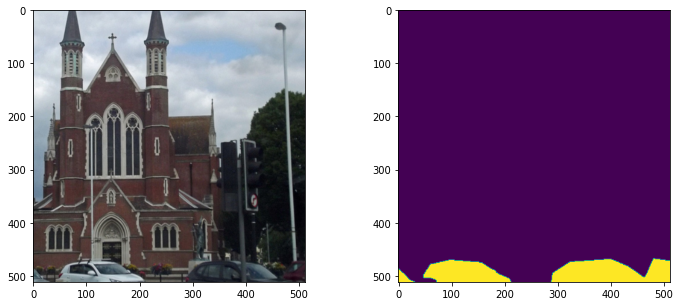

In [55]:
img, mask = train_data[22]
plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(TF.to_pil_image(img))
plt.subplot(122)
plt.imshow(mask.squeeze())
plt.show()

In [56]:
class VGG16(nn.Module):
    def __init__(self, num_classes=1000, rgbd=False):
        super(VGG16, self).__init__()

        if (rgbd):
          self.in_channels = 4
        else:
          self.in_channels = 3
        
        self.features = nn.Sequential(
            nn.Conv2d(self.in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

        self.initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [76]:
def normal_init(m, mean, std):
  """
  Helper function. Initialize model parameter with given mean and std.
  """
  if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
    # delete start
    m.weight.data.normal_(mean, std).to(device=device) 
    m.bias.data.zero_().to(device=device)
    # delete end

In [77]:
class generator(nn.Module):
  # initializers
  def __init__(self):
    super(generator, self).__init__()
    ###########################################################################
    # TODO: Build your Unet generator encoder with the layer sizes            #
    # You can also check the size with the model summary below                #
    ###########################################################################

    
    # layer 1 - C64
    self.encConv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(4, 4), stride=2, padding=1)
    # torch.nn.functional.leaky_relu(0.2), 

    # layer 2 - C128
    self.encConv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4, 4), stride=2, padding=1)
    self.encBatchNorm2 = nn.BatchNorm2d(128)
    #torch.nn.functional.leaky_relu(0.2) ,

    # layer 3 - C256
    self.encConv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(4, 4), stride=2, padding=1)
    self.encBatchNorm3 = nn.BatchNorm2d(256)
    #torch.nn.functional.leaky_relu(0.2),

    # layer 4 - C512
    self.encConv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(4, 4), stride=2, padding=1)
    self.encBatchNorm4 = nn.BatchNorm2d(512)
    #torch.nn.functional.leaky_relu(0.2),

    # layer 5 - C512
    self.encConv5 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(4, 4), stride=2, padding=1)
    self.encBatchNorm5 = nn.BatchNorm2d(512)
    #torch.nn.functional.leaky_relu(0.2),

    # layer 6 - C512
    self.encConv6 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(4, 4), stride=2, padding=1)
    self.encBatchNorm6 = nn.BatchNorm2d(512)
    #torch.nn.functional.leaky_relu(0.2),

    # layer 7 - C512
    self.encConv7 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(4, 4), stride=2, padding=1)
    self.encBatchNorm7 = nn.BatchNorm2d(512)
    #torch.nn.functional.leaky_relu(0.2),

    # layer 8 - C512
    self.encConv8 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(4, 4), stride=2, padding=1)
    #torch.nn.functional.leaky_relu(0.2)

      
    

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

    ###########################################################################
    # TODO: Build your Unet generator decoder with the layer sizes            #
    ###########################################################################
   
    # Layer 1 - C512
    self.decConv1 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=(4,4), stride=2, padding=1)
    self.decBatchNorm1 = nn.BatchNorm2d(512)
    #torch.nn.ReLU(),

    # Layer 2 - C512
    self.decConv2 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=(4,4), stride=2, padding=1)
    self.decBatchNorm2 = nn.BatchNorm2d(512)
    #torch.nn.ReLU(),

    # Layer 3 - C512
    self.decConv3 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=(4,4), stride=2, padding=1)
    self.decBatchNorm3 = nn.BatchNorm2d(512)
    #torch.nn.ReLU(),

    # Layer 4 - C512
    self.decConv4 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=(4,4), stride=2, padding=1)
    self.decBatchNorm4 = nn.BatchNorm2d(512)
    #torch.nn.ReLU(),

    # Layer 5 - C256
    self.decConv5 = nn.ConvTranspose2d(in_channels=1024, out_channels=256, kernel_size=(4,4), stride=2, padding=1)
    self.decBatchNorm5 = nn.BatchNorm2d(256)
    #torch.nn.ReLU(),

    # Layer 6 - C128
    self.decConv6 = nn.ConvTranspose2d(in_channels=512, out_channels=128, kernel_size=(4,4), stride=2, padding=1)
    self.decBatchNorm6 = nn.BatchNorm2d(128)
    #torch.nn.ReLU(),

    # Layer 7 - C64
    self.decConv7 = nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=(4,4), stride=2, padding=1)
    self.decBatchNorm7 = nn.BatchNorm2d(64)
    #torch.nn.ReLU(),

    # Layer 8 - C3
    self.decConv8 = nn.ConvTranspose2d(in_channels=128, out_channels=1, kernel_size=(4,4), stride=2, padding=1)
    self.decBatchNorm8 = nn.BatchNorm2d(3)
    #torch.nn.ReLU(),


    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################

  # weight_init
  def weight_init(self, mean, std):
    for m in self._modules:
      normal_init(self._modules[m], mean, std)

  # forward method
  def forward(self, input):
    ###########################################################################
    # TODO: Implement the forward pass of generator                           #
    ###########################################################################
    # encoding

    e1_c = self.encConv1(input)
    
    e2_c = self.encConv2(nn.functional.leaky_relu(e1_c, 0.2))
    e2_bn = self.encBatchNorm2(e2_c)

    e3_c = self.encConv3(nn.functional.leaky_relu(e2_bn, 0.2))
    e3_bn = self.encBatchNorm3(e3_c)
    
    e4_c = self.encConv4(nn.functional.leaky_relu(e3_bn, 0.2))
    e4_bn = self.encBatchNorm4(e4_c)

    e5_c = self.encConv5(nn.functional.leaky_relu(e4_bn, 0.2))
    e5_bn = self.encBatchNorm5(e5_c)

    e6_c = self.encConv6(nn.functional.leaky_relu(e5_bn, 0.2))
    e6_bn = self.encBatchNorm6(e6_c)

    e7_c = self.encConv7(nn.functional.leaky_relu(e6_bn, 0.2))
    e7_bn = self.encBatchNorm7(e7_c)

    e8_c = self.encConv8(nn.functional.leaky_relu(e7_bn, 0.2))

    enc_output = nn.functional.leaky_relu(e8_c, 0.2)

    # decoding
    # Hint: you can use torch.cat to concatenate the decoder and the encoder inputs

    d1_c = self.decConv1(enc_output)
    d1_bn = self.decBatchNorm1(d1_c)

    d2_in = torch.cat([e7_bn, d1_bn], 1)
  
    d2_c = self.decConv2(nn.functional.relu(d2_in))
    d2_bn = self.decBatchNorm2(d2_c) 

    d3_in = torch.cat([e6_bn, d2_bn], 1)

    d3_c = self.decConv3(nn.functional.relu(d3_in))
    d3_bn = self.decBatchNorm3(d3_c) 

    d4_in = torch.cat([e5_bn, d3_bn], 1)

    d4_c = self.decConv4(nn.functional.relu(d4_in))
    d4_bn = self.decBatchNorm4(d4_c) 

    d5_in = torch.cat([e4_bn, d4_bn], 1)

    d5_c = self.decConv5(nn.functional.relu(d5_in))
    d5_bn = self.decBatchNorm5(d5_c) 

    d6_in = torch.cat([e3_bn, d5_bn], 1)

    d6_c = self.decConv6(nn.functional.relu(d6_in))
    d6_bn = self.decBatchNorm6(d6_c) 

    d7_in = torch.cat([e2_bn, d6_bn], 1)

    d7_c = self.decConv7(nn.functional.relu(d7_in))
    d7_bn = self.decBatchNorm7(d7_c) 

    d8_in = torch.cat([e1_c, d7_bn], 1)

    d8_c = self.decConv8(nn.functional.relu(d8_in)) 

    output = nn.functional.sigmoid(d8_c)

    ###########################################################################
    #                              END OF YOUR CODE                           #
    ###########################################################################
    return output


In [82]:
def process_image(img):
  tmp = img.cpu().data.numpy().transpose(1, 2, 0)
  if len(tmp.shape) == 3 and tmp.shape[-1] == 1:
    tmp = np.reshape(tmp, (tmp.shape[0], tmp.shape[1]))
  return (tmp - np.min(tmp)) / (np.max(tmp) - np.min(tmp))
  
def show_result(G, x_, y_, num_epoch):
  predict_images = G(x_)

  # compute average x and y value. see what they are
  x_mean = torch.mean(predict_images)
  y_mean = torch.mean(y_)

  print('predict_images mean: ', x_mean)
  print('y_ mean: ', y_mean)
  
  fig, ax = plt.subplots(x_.size()[0], 3, figsize=(6,10))

  for i in range(x_.size()[0]):
    ax[i, 0].get_xaxis().set_visible(False)
    ax[i, 0].get_yaxis().set_visible(False)
    ax[i, 1].get_xaxis().set_visible(False)
    ax[i, 1].get_yaxis().set_visible(False)
    ax[i, 2].get_xaxis().set_visible(False)
    ax[i, 2].get_yaxis().set_visible(False)
    ax[i, 0].cla()
    ax[i, 0].imshow(process_image(x_[i]))
    ax[i, 1].cla()
    ax[i, 1].imshow(process_image(predict_images[i]))
    ax[i, 2].cla()
    ax[i, 2].imshow(process_image(y_[i]))
  
  plt.tight_layout()
  label_epoch = 'Epoch {0}'.format(num_epoch)
  fig.text(0.5, 0, label_epoch, ha='center')
  label_input = 'Input'
  fig.text(0.18, 1, label_input, ha='center')
  label_output = 'Output'
  fig.text(0.5, 1, label_output, ha='center')
  label_truth = 'Ground truth'
  fig.text(0.81, 1, label_truth, ha='center')

  plt.show()

In [ ]:


loss_func = torch.nn.BCEWithLogitsLoss()
def train_Unet(G, dataloader, num_epochs=20):
    #G_optimizer = optim.Adam(G.parameters(), lr=0.01, betas=[0.5, 0.999])
    
    # use SGD with momentum

    total_losses = []
    
    G_optimizer = optim.SGD(G.parameters(), lr=0.02, momentum=0.8)
    # loss_func = nn.MSELoss().to(device=device)

    for epoch in range(num_epochs):

        # have the learning rate decay
        base_lr = 0.005
        lr = base_lr * 0.8

        G_losses = []
        epoch_start_time = time.time()
        
        for img, mask in tqdm(dataloader):
            x = img.float().to(device=device) # images
            y = mask.to(device=device) # sementic segmentations
            # print(x.shape)
            # print(y.shape)
            # assert all elements of 0 < y < 1

            G.zero_grad() 
            model_ouput = G(x)
            
            loss = loss_func(model_ouput.float(), y.float())
            loss.backward()
            G_optimizer.step()

            loss_G = loss.detach().item()
            G_losses.append(loss_G)
            #print(loss_G) 
        epoch_end_time = time.time()
        per_epoch_ptime = epoch_end_time - epoch_start_time
        print('[%d/%d] - using time: %.2f seconds' % ((epoch + 1), num_epochs, per_epoch_ptime))
        print('loss of generator G: %.3f' % (torch.mean(torch.FloatTensor(G_losses))))
        #lr_reducer.step(torch.mean(torch.FloatTensor(G_losses)))
        total_losses.append(G_losses)
        
        with torch.no_grad():
            
            if epoch % 1 == 0:
                # show_result(G, fixed_x, fixed_y, (epoch+1))
                pass
        
        # append G_losses to total_losses
    
    return total_losses

In [86]:
G = generator()
G.to(device=device)  
loss = train_Unet(G, train_dl, num_epochs=10)

  0%|          | 1/1709 [00:00<22:39,  1.26it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])


  0%|          | 5/1709 [00:01<04:42,  6.03it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])


  0%|          | 7/1709 [00:01<03:34,  7.94it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])


  1%|          | 11/1709 [00:01<02:41, 10.52it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])


  1%|          | 13/1709 [00:01<02:27, 11.48it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])


  1%|          | 17/1709 [00:01<02:13, 12.63it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])


  1%|          | 19/1709 [00:02<02:10, 12.91it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])


  1%|▏         | 23/1709 [00:02<02:04, 13.50it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])
torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])


  1%|▏         | 25/1709 [00:02<02:03, 13.66it/s]

torch.Size([16, 3, 512, 512])
torch.Size([16, 1, 512, 512])


  1%|▏         | 25/1709 [00:02<03:15,  8.60it/s]


KeyboardInterrupt: 